# General Social Survey Data Analysis

## Data wrangling

In this notebook, we'll be analyzing the GSS (General Social Survey) dataset, which contains information about individuals collected from 1972 to 2022. Unfortunately, due to data constraints, I couldn't include the dataset in this repository. The dataset is available for download at: https://gss.norc.org/us/en/gss/get-the-data.html. You'll need to select the STATA version and download the cumulative dataset (the first option).

First, let's import the required libraries and our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_stata('gss_data/gss7222_r4.dta', convert_categoricals=False)

Due to the way the data was encoded, cell values are strings. Let's address that and make sure the data is formatted correctly.

In [2]:
# Get the list of column names
column_names = df.columns.tolist()

# Clean and convert object type columns
for name in column_names:
    if df[name].dtype == 'object':
        # Strip whitespace from the beginning and end of each string
        df[name] = df[name].str.strip()
        
        # Replace patterns like '.a', '.b', etc. with 'NaN'
        df[name] = df[name].str.replace(r'\.[a-z]', 'NaN', regex=True)
        
        # Replace 'NaN' strings with actual NaN values and convert to Int64
        df[name] = df[name].replace('NaN', np.nan).astype('Int64')

Now that we've fixed our DataFrame, let's take a quick look at it.

Note: you'll notice a lot of NAs, but we are keeping them in the interest of conserving the integrity of the data until we fit models to the data.

In [3]:
# Print information about the data
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
# print(df.info()) # Uncomment to see more detailed information

# Print the first 6 rows
df.head(6)

Rows: 72390, Columns: 6696


,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,agehef13,agehef14,hompoph,hhtype1_exp,batch,subsamprate,wtssps_nea,wtssnrps_nea,wtssps_next,wtssnrps_next
0,1972,1,1.0,NaN,NaN,NaN,205.0,50.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972,2,5.0,NaN,NaN,1.0,441.0,45.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1972,3,2.0,NaN,NaN,NaN,270.0,44.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1972,4,1.0,NaN,NaN,NaN,1.0,57.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1972,5,7.0,NaN,NaN,1.0,385.0,40.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1972,6,1.0,NaN,NaN,NaN,281.0,49.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

Let's explore some of the features in our data and visualize them. To begin, let's take a look at how many respondents we have per year to get an idea of how much data we're working with.

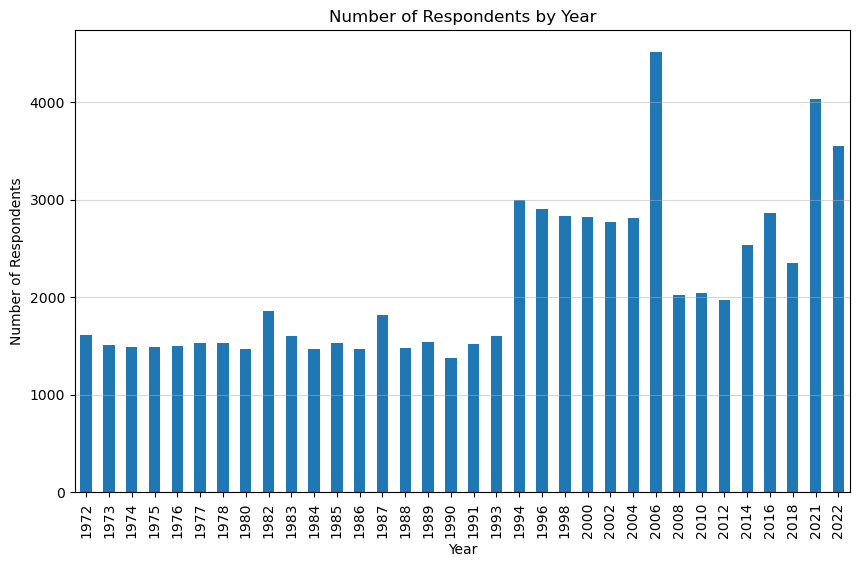

In [4]:
# Bar chart of the number of respondents by year
plt.figure(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Respondents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.5)
plt.show()

We can note a few things from this plot:
- The number of respondents increased dramatically during 1994 and 2006. Similarly, count decreased steeply in 2008.
- All odd years after 1998 are missing. This was due to changes in the way data was collected.
- The data has a few irregular skips in years: from 1991 to 1993 (for uknown reasons), and 2018 to 2020 (due to the COVID pandemic).

We must keep this in mind once we start doing regression and machine learning. For our purposes (and to simplify this analysis), we'll focus on the latest data from 2022. Let's explore the living conditions of our respondents. First, let's look at the household size distribution.

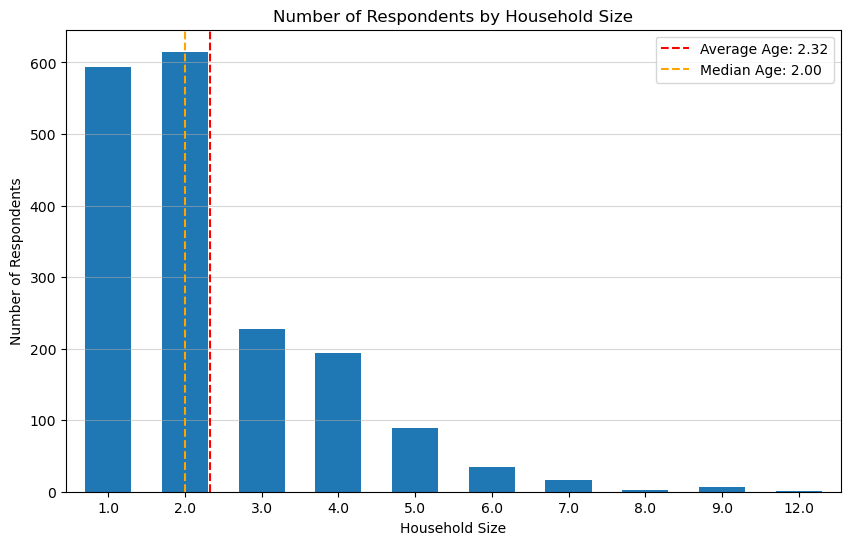

In [5]:
df_latest = df[df['year'] == 2022]

# Calculate average household size
average_hompop = df_latest['hompop'].mean()
median_hompop = df_latest['hompop'].median()

# Plot the bar chart
ax = df_latest['hompop'].value_counts().sort_index().plot(kind='bar', width=0.6, figsize=(10, 6))
plt.title('Number of Respondents by Household Size')
plt.xlabel('Household Size')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=0)

# Plot median and average lines
plt.axvline(average_hompop-1, color='r', linestyle='--', label=f'Average Age: {average_hompop:.2f}')
plt.axvline(median_hompop-1, color='orange', linestyle='--', label=f'Median Age: {median_hompop:.2f}')

# Fix the legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2])
plt.show()

Let's use the median as our measure of center since our plot is skewed. In this case, the median household size is 2, however, from the plot we can see that most households are either size 1 or 2. Let's dive deeper and investigate how these households are composed.

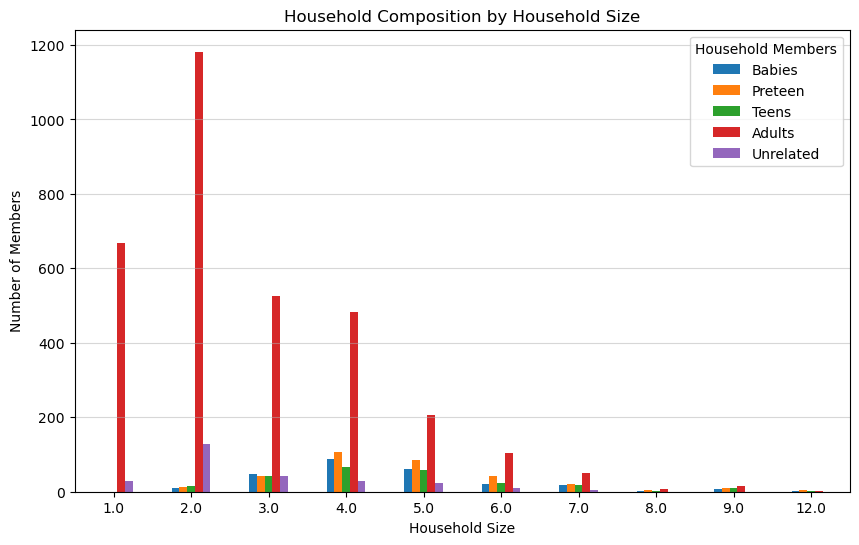

In [6]:
household_vars = ['babies', 'preteen', 'teens', 'adults', 'unrelat']
formatted_names = ['Babies', 'Preteen', 'Teens', 'Adults', 'Unrelated']

# Group the data by household size and sum the household variables
household_composition = df_latest.groupby('hompop')[household_vars].sum()

# Plot the grouped bar chart
household_composition.plot(kind='bar', figsize=(10, 6))
plt.title('Household Composition by Household Size')
plt.xlabel('Household Size')
plt.ylabel('Number of Members')
plt.legend(labels=formatted_names, title='Household Members')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

We can begin to see a pattern in the data: almost all households are composed of adults exclusively. By far, the most common configuration is a 2-adult household, which are most likely couples. We can verify this by graphing the distribution of marital status for 2 person households.

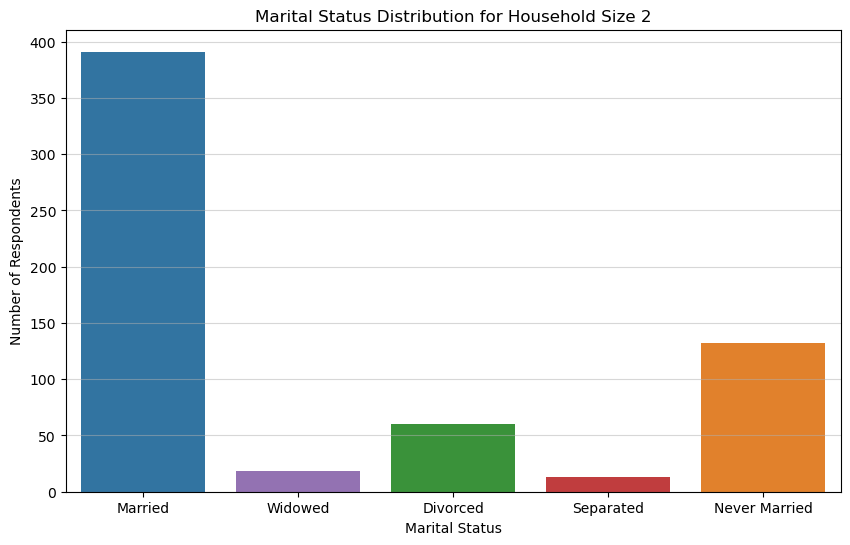

In [7]:
# Map marital status codes to labels
marital_mapping = {
    1.0: 'Married',
    2.0: 'Widowed',
    3.0: 'Divorced',
    4.0: 'Separated',
    5.0: 'Never Married'
}

# Filter the DataFrame for households with 2 people
marital_data = df_latest[df_latest['hompop'] == 2][['hompop', 'marital']].copy()

# Map the marital status codes to labels
marital_data['marital_status'] = marital_data['marital'].map(marital_mapping)

# Plot the relationship between marital status and household size
plt.figure(figsize=(10, 6))
sns.countplot(data=marital_data, x='marital_status', hue='marital_status', order=['Married', 'Widowed', 'Divorced', 'Separated', 'Never Married'], legend=False)
plt.title('Marital Status Distribution for Household Size 2')
plt.xlabel('Marital Status')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.5)
plt.show()

Just as expected, a large chunk of the respondents in 2-person households tend to be married. Despite this, there's also a good number that are divorced or have never been married. Now, let's find out the ages of our respondents.

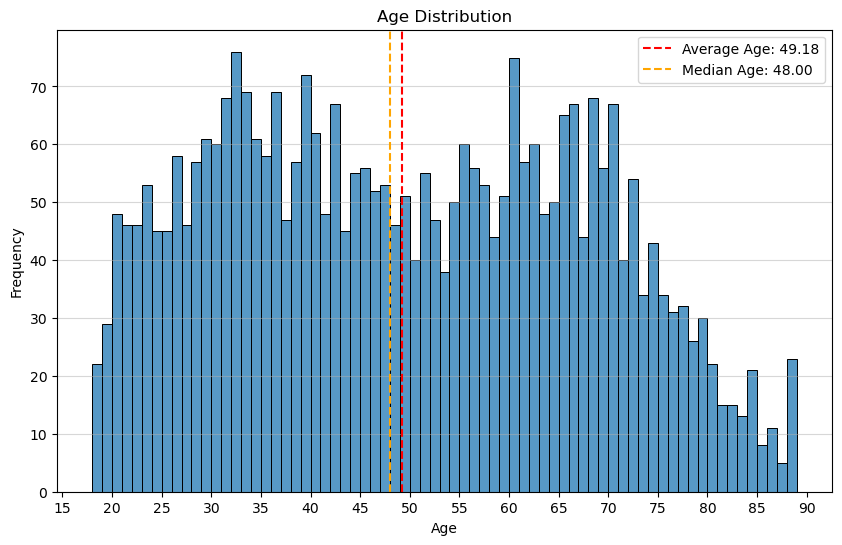

In [8]:
# Calculate average and median age
average_age = df_latest['age'].mean()
median_age = df_latest['age'].median()

plt.figure(figsize=(10, 6))
sns.histplot(df_latest['age'], bins=df_latest['age'].nunique()-1)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.xticks(range(15, 95, 5))
plt.axvline(average_age, color='r', linestyle='--', label=f'Average Age: {average_age:.2f}')
plt.axvline(median_age, color='orange', linestyle='--', label=f'Median Age: {median_age:.2f}')
plt.legend()
plt.show()

We can see that the median age for respondents is 48 years. However, we can discern a bimodal distribution, so our usual measures of center won't work as nicely. Let's subset the dataset to include only households of size 2 and plot the age distribution again to see if we can gather more information.

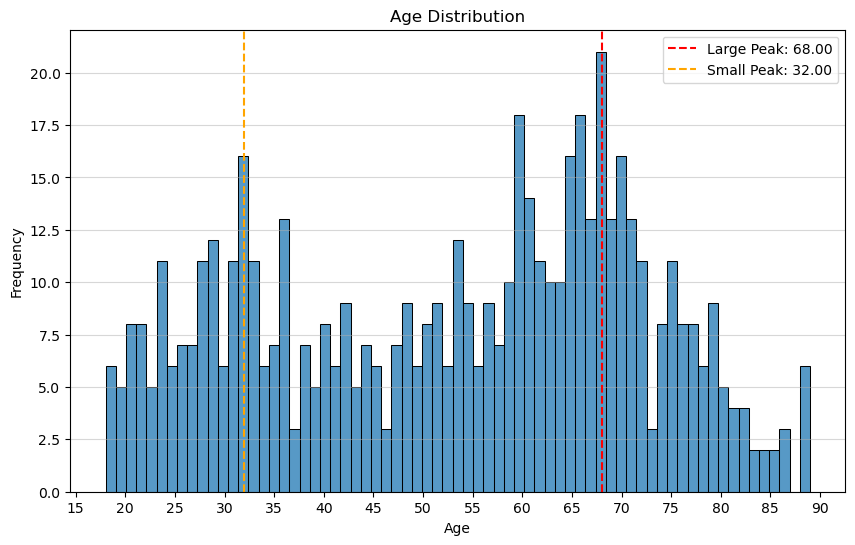

In [11]:
households = df_latest[df_latest['hompop'] == 2]

# Calculate peaks
median_age = households['age'].median()
large_peak = households[households['age'] >= median_age]['age'].mode().values[0]
small_peak = households[households['age'] < median_age]['age'].mode().values[0]

plt.figure(figsize=(10, 6))
sns.histplot(households['age'], bins=households['age'].nunique()-1)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.xticks(range(15, 95, 5))
plt.axvline(large_peak, color='r', linestyle='--', label=f'Large Peak: {large_peak:.2f}')
plt.axvline(small_peak, color='orange', linestyle='--', label=f'Small Peak: {small_peak:.2f}')
plt.legend()
plt.show()

Surprisingly enough, it turns out most of the respondents in 2 person households, will be either around 60 or 25-26, seen in our bimodal distribution.

## Data Modeling

Now, let's try to fit a few models that attempt to predict `income` using variables that have more than 25% NAs. For this task, we'll only be using data from 1998-2022. We'll attempt to fit a Decision Tree and a Random Forest Classifier.

In [39]:
### Data Preprocessing ###

# Filter the data for 2021-2022
df_model = df[df['year'].isin(range(1998, 2023))].copy()

# Drop rows with missing values in the 'income' column
df_model.dropna(subset=['income'], inplace=True)

# Drop columns with more than 30% missing values
df_model.dropna(thresh=0.7*len(df_model), axis=1, inplace=True)

# Fill missing values with the median
df_model.fillna(df.median(), inplace=True)

# Assign weights based on the year
sample_weights = np.where(df_model['year'] <= 2018, df_model['wtssall'], df_model['wtssps'])

# Define the features and target variable
X = df_model.drop(columns=['income'])
y = df_model['income']

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Initialize the classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)

# Define the scoring metrics with zero_division parameter
scoring = {
	'accuracy': 'accuracy',
	'precision_macro': make_scorer(precision_score, average='macro', zero_division=1),
	'recall_macro': make_scorer(recall_score, average='macro', zero_division=1),
	'f1_macro': make_scorer(f1_score, average='macro', zero_division=1)
}

# Cross-validate the models
cv = KFold(n_splits=5, shuffle=True, random_state=42)
dt_scores = cross_validate(dt_classifier, X, y, cv=cv, scoring=scoring, params={'sample_weight': sample_weights}, return_train_score=False)
rf_scores = cross_validate(rf_classifier, X, y, cv=cv, scoring=scoring, params={'sample_weight': sample_weights}, return_train_score=False)

# Print the results
print('Decision Tree Classifier:')
for metric, values in dt_scores.items():
    print(f'{metric}: {values.mean():.4f}')

print('\nRandom Forest Classifier:')
for metric, values in rf_scores.items():
    print(f'{metric}: {values.mean():.4f}')

Decision Tree Classifier:
fit_time: 1.1414
score_time: 0.0242
test_accuracy: 0.7849
test_precision_macro: 0.6582
test_recall_macro: 0.6667
test_f1_macro: 0.6240

Random Forest Classifier:
fit_time: 10.0297
score_time: 0.2264
test_accuracy: 0.8499
test_precision_macro: 0.5072
test_recall_macro: 0.4072
test_f1_macro: 0.4066


We can see that household composition, age, and marital status are reasonably good predictors of income, since we get 0.78 and 0.84 for accuracy. You can also see that you get a higher accuracy score using a Random Forest algorithm, but at the cost of precision and recall. In this case, a decision tree might be the best choice, as it less computationally expensive, it's more interpretable, and it seems to have a reasonable score in all metrics.

Let's see what variables both models prioritized to understand why they might have differences in their score. Due to space constraints, we'll only check the first 5.

In [43]:
# Fit the models
rf_classifier.fit(X, y)
dt_classifier.fit(X, y)

# Get the top 5 features
dt_feature = pd.Series(dt_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)[:5]
rf_feature = pd.Series(rf_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)[:5]

# Print the top 5 features
print('Decision Tree Feature Importances:')
print(dt_feature)

print('\nRandom Forest Feature Importances:')
print(rf_feature)

Decision Tree Feature Importances:
realinc    0.645671
vstrat     0.190097
coninc     0.114236
year       0.036166
sample     0.001320
dtype: float64

Random Forest Feature Importances:
coninc     0.241243
realinc    0.234910
vstrat     0.017006
sei10      0.013828
finrela    0.013803
dtype: float64


As we can see, most variables are different, except realinc and vstrat, which appear in both lists but in different positions. This might give us insight when trying to prioritize columns and build a more robust model.

And that's it for today. This is just the beginning! You can continue analyzing this dataset and come up with your own conclusions. Good luck!